Loaded rows: 375913
Created wage_cat (Low ≤ 200.00, Medium ≤ 300.00)
Rows after cleaning: 375913
Classes: ['High' 'Low' 'Medium']


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



✅ Logistic Regression Accuracy: 44.28%

Classification Report:
              precision    recall  f1-score   support

        High       0.99      0.02      0.03     20026
         Low       0.49      0.95      0.64     31182
      Medium       0.24      0.14      0.18     23975

    accuracy                           0.44     75183
   macro avg       0.57      0.37      0.28     75183
weighted avg       0.54      0.44      0.33     75183



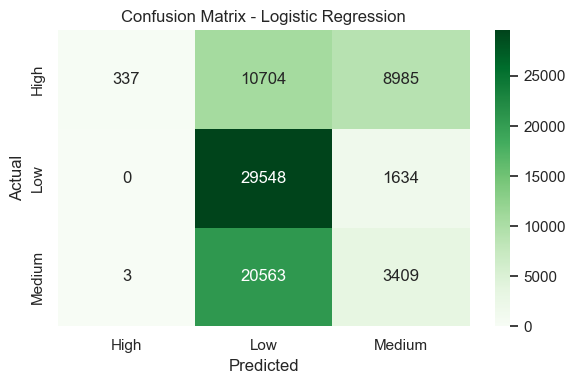

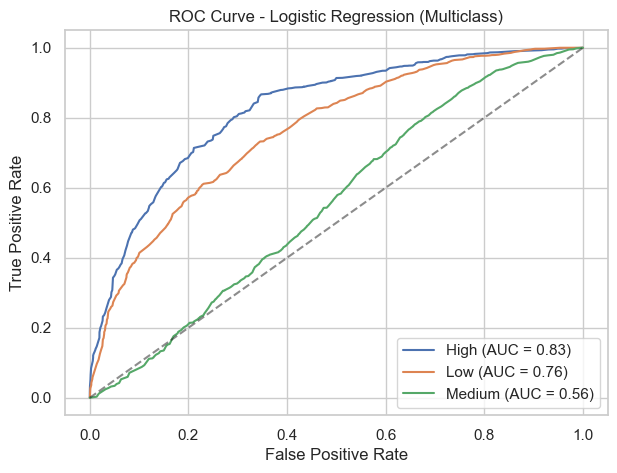

C:\Users\HP\AppData\Local\Temp\ipykernel_25984\2131597716.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


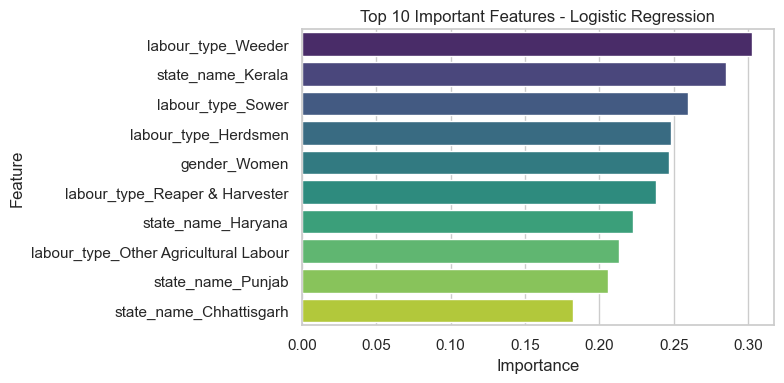

In [1]:
# logistic_regression_agri_wages.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# ---------------- CONFIG ----------------
FILE = "cleaned_agri_wages.csv"
RANDOM_STATE = 42
sns.set(style="whitegrid")

# ---------------- LOAD ----------------
df = pd.read_csv(FILE)
print("Loaded rows:", len(df))

# ---------------- CREATE TARGET ----------------
if "wage_cat" not in df.columns or df["wage_cat"].isna().any():
    low_thr, high_thr = np.percentile(df["monthly_average_wage"].dropna(), [33.3, 66.6])
    def wage_group(x):
        if x <= low_thr: return "Low"
        elif x <= high_thr: return "Medium"
        else: return "High"
    df["wage_cat"] = df["monthly_average_wage"].apply(wage_group)
    print(f"Created wage_cat (Low ≤ {low_thr:.2f}, Medium ≤ {high_thr:.2f})")

# ---------------- SELECT FEATURES ----------------
features = ["state_name", "labour_type", "gender"]
target = "wage_cat"
df = df.dropna(subset=features + [target])
print("Rows after cleaning:", len(df))

# ---------------- ENCODE CATEGORICAL FEATURES ----------------
X = pd.get_dummies(df[features].astype(str), drop_first=True)
y_le = LabelEncoder()
y = y_le.fit_transform(df[target])
class_names = y_le.classes_
print("Classes:", class_names)

# ---------------- SPLIT & SCALE ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- TRAIN MODEL ----------------
model = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=RANDOM_STATE
)
model.fit(X_train_scaled, y_train)

# ---------------- EVALUATE ----------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Logistic Regression Accuracy: {acc*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

# ---------------- ROC CURVES ----------------
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
plt.figure(figsize=(7, 5))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Multiclass)")
plt.legend(loc="lower right")
plt.show()

# ---------------- FEATURE IMPORTANCE ----------------
importance = np.abs(model.coef_).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Top 10 Important Features - Logistic Regression")
plt.tight_layout()
plt.show()
